<a href="https://colab.research.google.com/github/mathewhall100/SIIM-pneumothorax-model/blob/master/SIIM_pneumothorax_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SIIM-ACR pneumothorax segmentation Kaggle competition

Kaggle competition, to develop a model to classify (and if present, segment) pneumothorax from a set of chest radiographic images.

Model construicted using fastai library on top of pytorch using a UNET and resnet34 arcitecture. Achieved position 413/1056 on leaderboard at time submission.

## Saving data files

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

## Setup notebook

Auto reloads library if code changes
instructs jupyter to plot matplotlib plots in notebook cells

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install nbformat
!pip install nbconvert==5.4.1

## Import Libraries

In [15]:
import os
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import fastai
from fastai.vision import *
from fastai.callbacks import *


[autoreload of nbconvert.filters.markdown_mistune failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/extensions/autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
ValueError: image() requires a code object with 1 free vars, not 0
]


In [16]:
!pip install -U pydicom

     |████████████████████████████████| 7.1MB 1.4MB/s 


In [0]:
import pydicom

## Verifying  status

In [18]:
fastai.__version__

'1.0.54'

In [19]:
print("GPU: ", torch.cuda.is_available())
if torch.cuda.is_available() == True:
  print("Device = ", torch.device(torch.cuda.current_device()))
  print("PyTorch version - ", torch.__version__)
  print("Cuda version - ", torch.version.cuda)
  print("cuDNN version - ", torch.backends.cudnn.version())
print("python PIL version - ", PIL.PILLOW_VERSION)

GPU:  True
Device =  cuda:0
PyTorch version -  1.1.0
Cuda version -  10.0.130
cuDNN version -  7501
python PIL version -  4.3.0


## Utility functions

## Get data

Data downloaded to my google drive from [here](https://www.kaggle.com/jesperdramsch/siim-acr-pneumothorax-segmentation-data)

In [20]:
path128 = Path(f'{root_dir}/Colab Notebooks/data/kaggle/siim-acr-pneumothorax-segmentation-data-128/data128')
path256 = Path(f'{root_dir}/Colab Notebooks/data/kaggle/siim-acr-pneumothorax-segmentation-data-256/data256')
os.listdir(path256)

['test',
 'train',
 'masks',
 'siim-pneumothorax-256-stage2-rn34.pth',
 'siim-pneumothorax-256-baseline-rn34.pth']

In [21]:
path_train = path256/'train'
path_masks = path256/'masks'
print(path_train)
print(path_masks)

/content/gdrive/My Drive/Colab Notebooks/data/kaggle/siim-acr-pneumothorax-segmentation-data-256/data256/train
/content/gdrive/My Drive/Colab Notebooks/data/kaggle/siim-acr-pneumothorax-segmentation-data-256/data256/masks


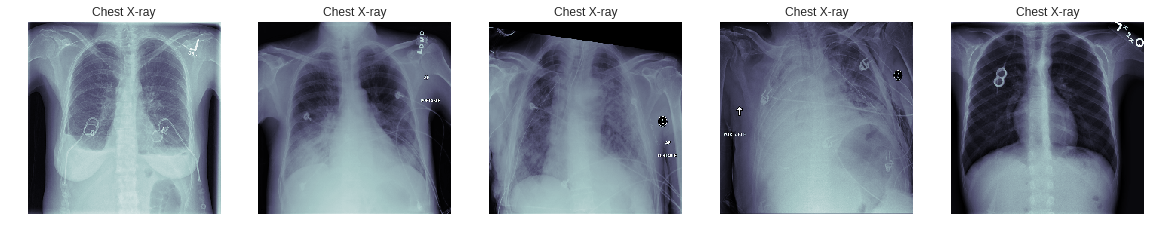

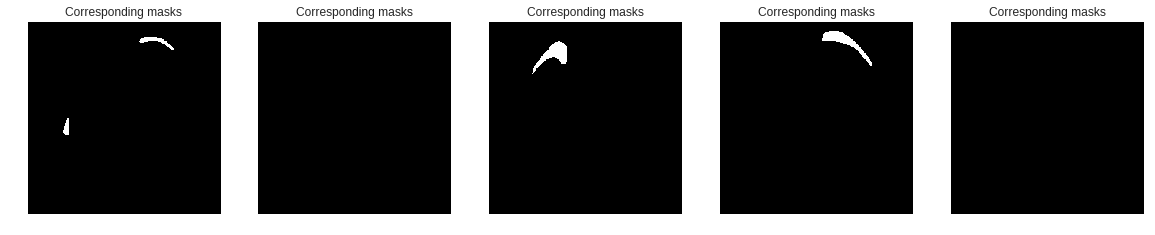

In [23]:
# Show example image from train fil

def show_imgs(images, title, mask=False):
  plt.figure(figsize=(20,10))
  columns = 5
  for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    if mask: image = str(image).replace("train", "masks")
    img = plt.imread(f'{image}')    
    plt.axis('off')
    plt.title(title)
    plt.imshow(img,cmap='bone')
    
    
fnames = get_image_files(path_train)
images = fnames[:5]
show_imgs(images, "Chest X-ray")
show_imgs(images, "Corresponding masks", True)


## Define parameters

In [0]:
sz = 256
bs = 8

## Set path to correct size of training images

In [0]:
path = path256

## Create databunch

In [0]:
# Set mask opener to div=True. Required for binary masks which have values 0 and 255. Converts class '255' to '1'.
# Otherwise get a device side assert error when fitting.

class SegmentationLabelList(SegmentationLabelList):
  def open(self, fn): return open_mask(fn, div=True)
  
class SegmentationItemList(SegmentationItemList):
  _label_cls = SegmentationLabelList

In [0]:
get_y_fn = lambda x : str(x).replace('train', 'masks')

In [0]:
# Set test set transforms to 'False' to avoid an error applying transforms to the absent masks of the test set.
def transform(self, tfms, **kwargs):
    print("train set transforms: ", tfms[0])
    print("valid set transforms: ", tfms[1])
    for i, v in kwargs.items():
      print (i, ": ", v)
    if not tfms: tfms=(None,None)
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    if self.test: self.test.transform(tfms[1], size=kwargs['size'], tfm_y=False)
    return self
fastai.data_block.ItemLists.transform = transform

In [29]:
# Set random seed so we always get same test/validation set 
random.seed(142)

# Data block API
src = (SegmentationItemList.from_folder(path=path/'train')
      .split_by_rand_pct(0.2)
      .label_from_func(get_y_fn, classes=[0, 1])
      .add_test((path/'test').ls(), label=None)
      )

data = (src.transform(get_transforms(), size=sz, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats)
      )

train set transforms:  [RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmPixel (flip_lr), kwargs={}, p=0.5, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmCoord (symmetric_warp), kwargs={'magnitude': (-0.2, 0.2)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (rotate), kwargs={'degrees': (-10.0, 10.0)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.1), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True), RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resol

In [0]:
data

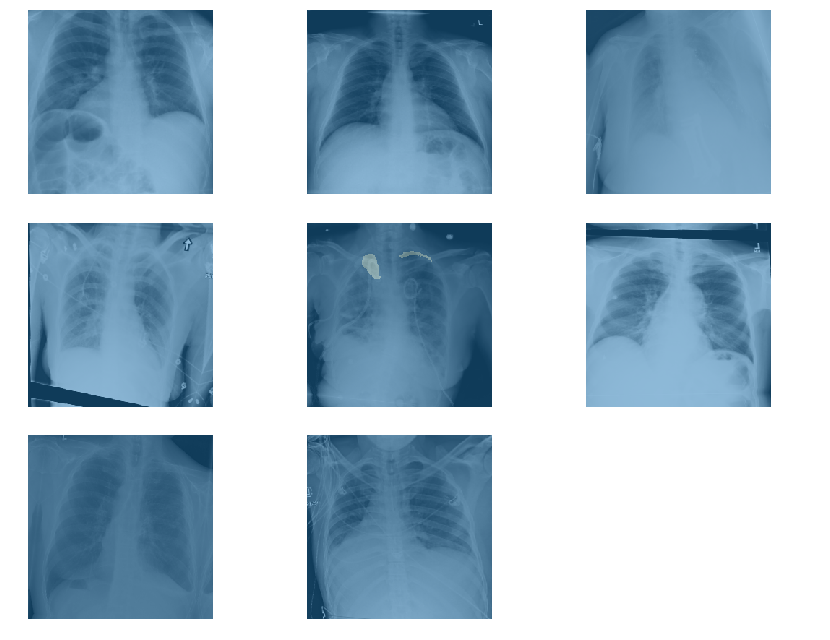

In [30]:
data.show_batch(figsize=(12, 9))


## Fit

In [0]:
noise_th = 75.0*(sz/128.0)**2 #threshold for the number of predicted pixels
best_thr0 = 0.2 #preliminary value of the threshold for metric calculation

# modification to fast ai dice metric to reflect competition metric 
#  'Hypercolumns pneumothorax fastai' kernal by iafoss corrects for this
def dice(input:Tensor, targs:Tensor, iou:bool=False, eps:float=1e-8)->Rank0Tensor:
    n = targs.shape[0]
    input = torch.softmax(input, dim=1)[:,1,...].view(n,-1)  # use softmax instead of argmax
    input = (input > best_thr0).long()
    input[input.sum(-1) < noise_th,...] = 0.0 
    # input = input.argmax(dim=1).view(n,-1)
    targs = targs.view(n,-1)
    intersect = (input * targs).sum(-1).float()
    union = (input+targs).sum(-1).float()
    if not iou: return ((2.0*intersect + eps) / (union+eps)).mean()
    else: return ((intersect + eps) / (union - intersect + eps)).mean()

In [32]:
learn = unet_learner(data, models.resnet34, metrics=[dice])


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 91221680.54it/s]


In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


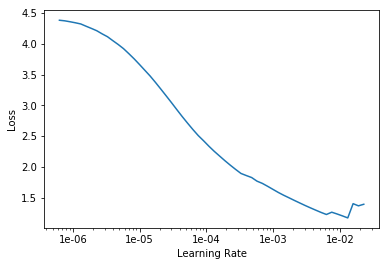

In [23]:
learn.recorder.plot()

In [33]:
lr = 5e-04
learn.fit_one_cycle(6, lr)

epoch,train_loss,valid_loss,dice,time
0,0.016868,0.016379,0.779178,1:20:07
1,0.016727,0.012625,0.712602,18:16
2,0.014152,0.013198,0.785762,18:15
3,0.012282,0.010686,0.792379,18:14
4,0.010689,0.010242,0.795491,18:12
5,0.010277,0.009171,0.794955,18:10


In [0]:
learn.save(path/'siim-pneumothorax-256-baseline-rn34')

In [0]:
learn.load(path/'siim-pneumothorax-256-baseline-rn34')

In [0]:
learn.unfreeze()

In [66]:
learn.fit_one_cycle(6, wd=0.01, max_lr=slice(lr/50, lr/5), callbacks=[SaveModelCallback(learn, monitor='dice', every='improvement', name='bestmodel')])

epoch,train_loss,valid_loss,dice,time
0,0.010234,0.009753,0.797612,19:14
1,0.009740,0.009248,0.787675,19:16
2,0.010138,0.009014,0.793924,19:17
3,0.008955,0.008940,0.794357,19:17
4,0.007895,0.008911,0.802170,19:10
5,0.008941,0.008720,0.798505,19:19


Better model found at epoch 0 with dice value: 0.7976124882698059.
Better model found at epoch 4 with dice value: 0.8021695017814636.


## Reload best model and save

In [0]:
learn.load('bestmodel')
learn.save(path/'siim-pneumothorax-256-stage2-rn34')

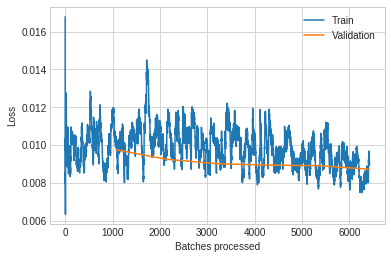

In [67]:
learn.recorder.plot_losses()

## Get predictions for validation set and calculate optimal threshold

In [0]:
# get predictions for validation set 
preds, ys = learn.get_preds()
preds = preds[:, 1, ...]
ys = ys.squeeze()

preds_ = preds
targs_ = ys

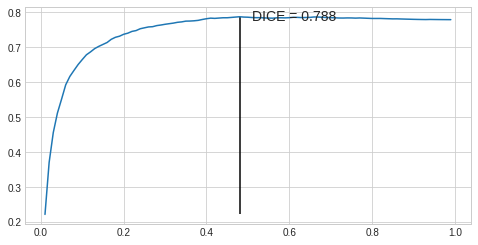

best Threshold:  0.48000000000000004


In [71]:
# Get best threshold for predictions
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)
  
  
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)
  
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()
print("best Threshold: ", best_thr)

In [72]:
# establish a noise threshold at .45% of total pixels in images
noise_thresh = (sz**2)*0.0015
print("noise threshold: ", noise_thresh, "pixels")

noise threshold:  98.304 pixels


## Examine data

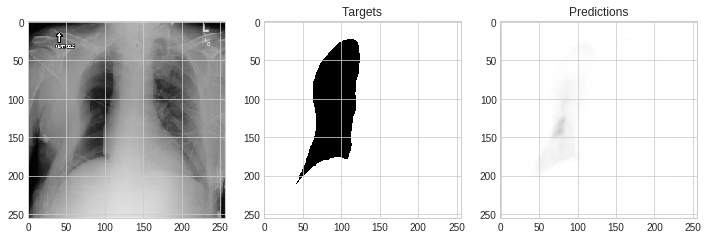

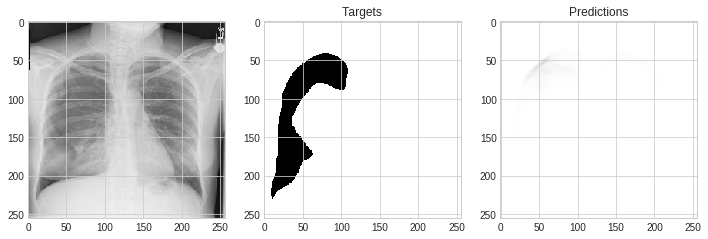

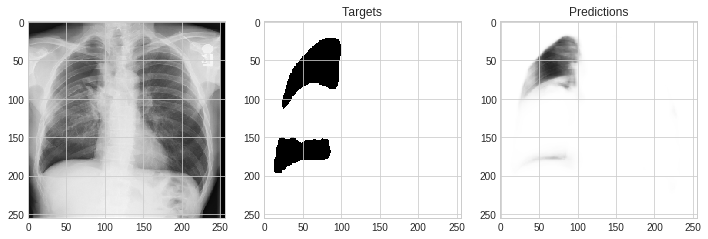

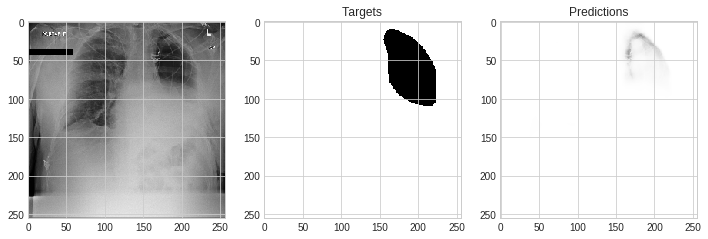

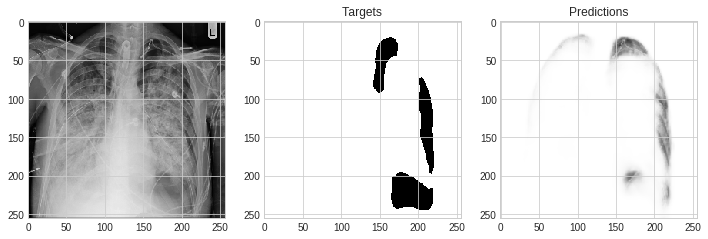

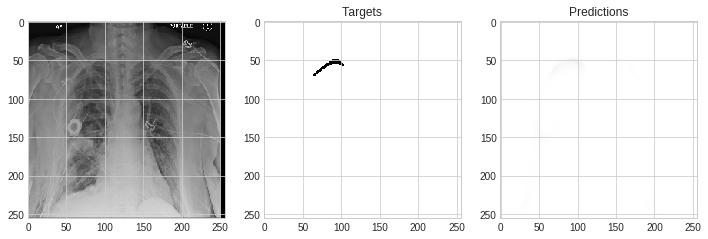

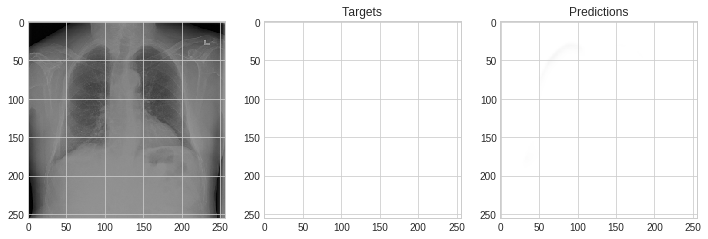

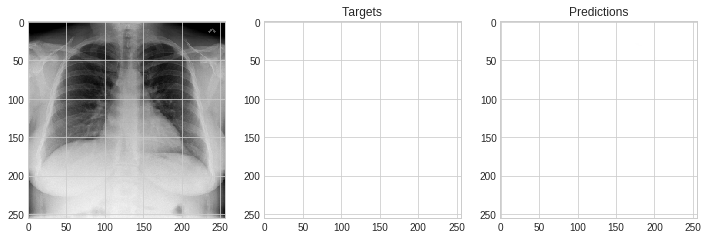

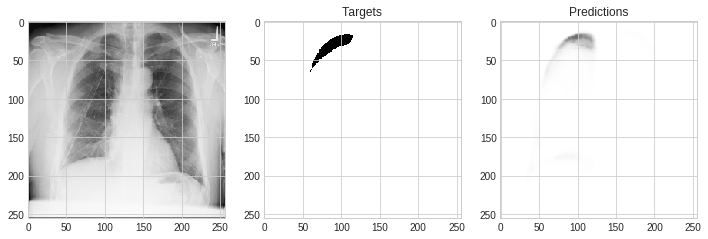

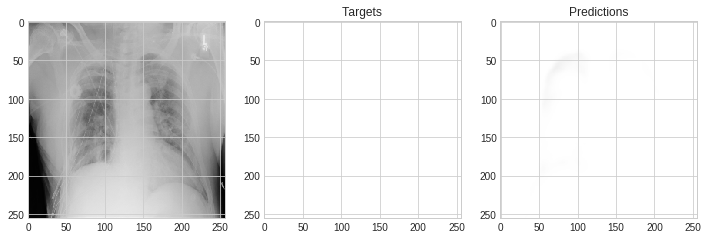

In [53]:
# Examine some of the predictions

def show_preds(plot_idx, rows):
    for idx in plot_idx:
      fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
      ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
      ax1.imshow(ys[idx], vmin=0, vmax=1)
      ax2.imshow(preds[idx], vmin=0, vmax=1)
      ax1.set_title('Targets')
      ax2.set_title('Predictions')

rows = 5
masks_sz = ys.sum((1,2))   # calculate total num pixels in target masks
largest_masks = masks_sz.sort(descending=True).indices[:rows]     # get the indices of the largest 5 masks 
smallest_masks = masks_sz[masks_sz>noise_thresh].sort(descending=False).indices[:rows]     # get the indices of the smallest 5 masks above noise threshold

print("Largest 5 pneumothoraces in validation set", fontsize=18)
show_preds(largest_masks, rows)
print("Smallest 5 pneumothoraces in validation set", fontsize=18)
show_preds(smallest_masks, rows)


Total pneumothoraces in validation set : 473
Total pneumothoraces in validation set above noise threshold 434


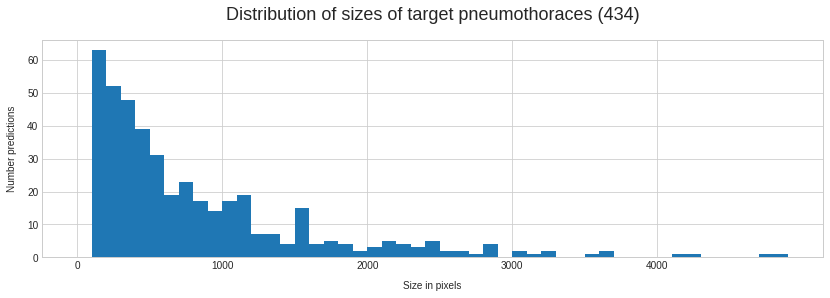

In [54]:
import seaborn as sns

# plot pneumothorax sizes as a histogram
def plt_ptxs(data_hist, title):
  plt.style.use('seaborn-whitegrid')
  plt.figure(figsize=(14, 4))
  plt.hist(data_hist, bins=[i*100 for i in range(50)])
  plt.title(f"{title} ({len(data_hist)})", fontsize=18, pad=20)
  plt.xlabel("Size in pixels", labelpad=10)
  plt.xticks([i*1000 for i in range(5)])
  plt.ylabel("Number predictions", labelpad=10)
  plt.show()

data_hist = masks_sz[masks_sz>noise_thresh]

print("Total pneumothoraces in validation set :", len(masks_sz[masks_sz>0]))
print("Total pneumothoraces in validation set above noise threshold", len(data_hist))

plt_ptxs(data_hist, "Distribution of sizes of target pneumothoraces")

## Get prediction for test set 

In [73]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
preds = (preds[:,1,...]>best_thr).long().numpy()
print(preds.sum())

48467


## Examine results

Number non-zero predictions in prediction set : 132
Number predicted pneumothoraces above noise threshold 73


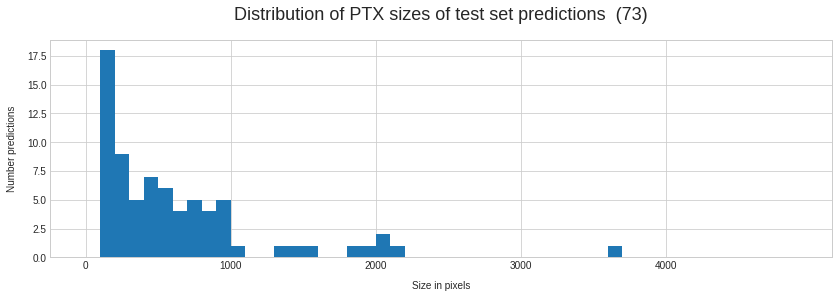

In [75]:
# Sizes of pneumothoraces in test set predictions
masks_sz = preds.sum((1,2))
data_hist = masks_sz[masks_sz>noise_thresh]

print("Number non-zero predictions in prediction set :", len(masks_sz[masks_sz>0]))
print("Number predicted pneumothoraces above noise threshold", len(data_hist))

plt_ptxs(data_hist, "Distribution of PTX sizes of test set predictions ")



In [0]:
# Set predcitions to 0 if total pixels fewer than noise.thresh
preds[preds.sum((1,2)) < noise_thresh] = 0.0

## Prepare submission file

In [0]:
# convert masks to rle for submission (code provided by competition page)
def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

In [79]:
# Generate rle encodings (first convert images to the original size)
rles = []
for p in progress_bar(preds):
    im = PIL.Image.fromarray((p.T*255).astype(np.uint8)).resize((1024,1024))
    im = np.asarray(im)
    rles.append(mask2rle(im, 1024, 1024))

In [80]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.to_csv('submission3.csv', index=False)
sub_df.head(50)

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6637.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6232.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6996.151787520...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6141.151787519...,-1
4,1.2.276.0.7230010.3.1.4.8323329.6351.151787519...,-1
5,1.2.276.0.7230010.3.1.4.8323329.5899.151787519...,-1
6,1.2.276.0.7230010.3.1.4.8323329.6449.151787519...,237916 32 992 32 992 32 992 32 960 64 960 64 9...
7,1.2.276.0.7230010.3.1.4.8323329.6551.151787519...,-1
8,1.2.276.0.7230010.3.1.4.8323329.6695.151787519...,-1
9,1.2.276.0.7230010.3.1.4.8323329.6194.151787519...,-1
